In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


/var/folders/4r/jhc99db14v58mjmncgtry0kc0000gn/T/ipykernel_30237/3606260328.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Base Unrealized Gain/Loss'] = df['Base Unrealized Gain/Loss'].replace(',', '', regex=True).astype(float)
/var/folders/4r/jhc99db14v58mjmncgtry0kc0000gn/T/ipykernel_30237/3606260328.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Base Market Value'] = df['Base Market Value'].replace(',', '', regex=True).astype(float)
/var/folders/4r/jhc99db14v58mjmncgtry0kc0000gn/T/ipy

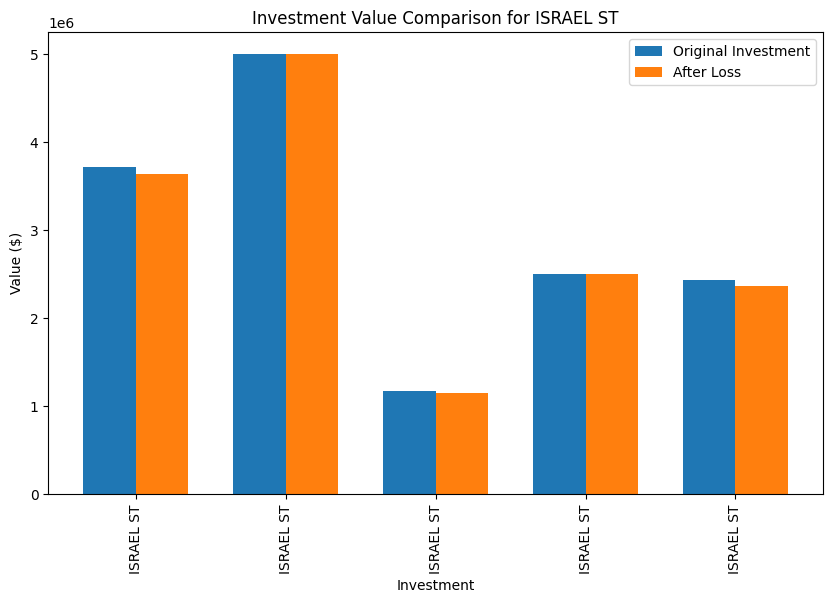

In [2]:
gasb_data = pd.read_csv('../data/input/Copy of BNY Mellon GASB Holdings.csv')
leqtf_data = pd.read_csv('../data/input/Copy of BNY Mellon GASB Holdings.csv')

# List of companies to exclude
excluded_companies = [
    "BOEING CO/THE", "INTEL CORP", "MCDONALD'S CORP", "APPLE INC", "AMAZON.COM INC",
    "MICROSOFT CORP", "CHEVRON CORP", "EXXON MOBIL CORP", "LOCKHEED MARTIN CORP"
]

# Function to calculate percentage of unrealized loss and compare it
def calculate_loss_percentage(df):
    df['Base Unrealized Gain/Loss'] = df['Base Unrealized Gain/Loss'].replace(',', '', regex=True).astype(float)
    df['Base Market Value'] = df['Base Market Value'].replace(',', '', regex=True).astype(float)
    
    # Calculate the percentage of unrealized loss
    df['Percentage Unrealized Loss'] = df.apply(
        lambda row: (row['Base Unrealized Gain/Loss'] / row['Base Market Value']) * 100 if row['Base Market Value'] != 0 else 0,
        axis=1
    )

    # Filter data for ISRAEL ST and others
    israel_st_loss = df[df['Security Description1'].str.contains("ISRAEL", na=False)]['Percentage Unrealized Loss']
    other_loss = df[~df['Security Description1'].str.contains("ISRAEL", na=False)]['Percentage Unrealized Loss']
    
    return israel_st_loss, other_loss

# Function to filter out specified companies and recalculate losses
def filter_and_recalculate_losses(df):
    # Filter out the specified companies
    filtered_df = df[~df['Security Description1'].str.contains('|'.join(excluded_companies), case=False, na=False)]
    
    filtered_israel_st_loss, filtered_other_loss = calculate_loss_percentage(filtered_df)
    
    return filtered_israel_st_loss.describe(), filtered_other_loss.describe()

# Apply filtering and recalculation to both datasets
filtered_gasb_israel_st_loss, filtered_gasb_other_loss = filter_and_recalculate_losses(gasb_data)
filtered_leqtf_israel_st_loss, filtered_leqtf_other_loss = filter_and_recalculate_losses(leqtf_data)

# Function to prepare data for plotting the original investment vs. investment after loss
def prepare_plot_data(df):
    # Filter for Israel ST investments
    israel_st_data = df[df['Security Description1'].str.contains("ISRAEL", na=False)]
    
    israel_st_data['Base Market Value'] = israel_st_data['Base Market Value'].replace(',', '', regex=True).astype(float)
    israel_st_data['Base Unrealized Gain/Loss'] = israel_st_data['Base Unrealized Gain/Loss'].replace(',', '', regex=True).astype(float)
    
    israel_st_data['Investment After Loss'] = israel_st_data['Base Market Value'] + israel_st_data['Base Unrealized Gain/Loss']
    
    plot_data = israel_st_data[['Security Description1', 'Base Market Value', 'Investment After Loss']]
    
    return plot_data

plot_data_gasb = prepare_plot_data(gasb_data)

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(plot_data_gasb))
bar_width = 0.35

rects1 = ax.bar(index, plot_data_gasb['Base Market Value'], bar_width, label='Original Investment')
rects2 = ax.bar(index + bar_width, plot_data_gasb['Investment After Loss'], bar_width, label='After Loss')

ax.set_xlabel('Investment')
ax.set_ylabel('Value ($)')
ax.set_title('Investment Value Comparison for ISRAEL ST')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(plot_data_gasb['Security Description1'], rotation=90)
ax.legend()

plt.show()